# Relate timing and magnitude of velocity with PDDs and terminus position (using timeseries by section and calculating mean)

In [25]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy
import geoutils as gu
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.signal import detrend

Weather loaded
Terminus positions loaded


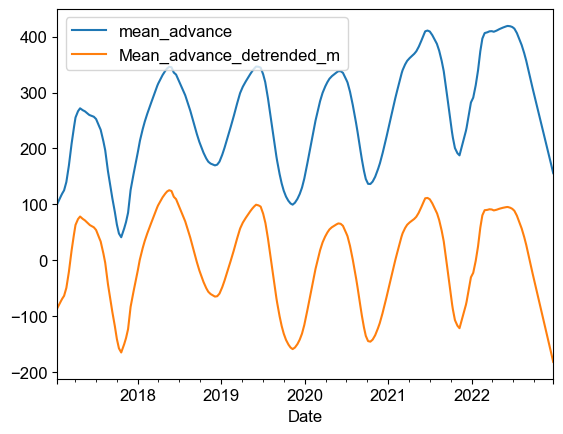

In [26]:
out_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

crs = 'EPSG:3413'

# -----Air temperature --> PDDs
air_fn = os.path.join(data_path, 'data', 'Yakutat_2000_2023.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air['Date_Time'] = pd.DatetimeIndex(air['Date_Time'])
air.rename(columns={'Date_Time': 'Date'}, inplace=True)
print('Weather loaded')


# -----Terminus (all sections) 
term_fn = os.path.join(data_path, 'data/compiled_timeseries_by_terminus_section', 'advance_by_section.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)

# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
term.reset_index(inplace=True)

term['mean_advance'] = term[[
    'section_B advance position [m]', #   'section_A advance position [m]', 
    'section_C advance position [m]',
    'section_D advance position [m]', 
    'section_E advance position [m]']].mean(axis=1)

term['Mean_advance_detrended_m'] = detrend(term['mean_advance'])

term.set_index('Date')[['mean_advance', 'Mean_advance_detrended_m']].plot()
print('Terminus positions loaded')

Velocity loaded


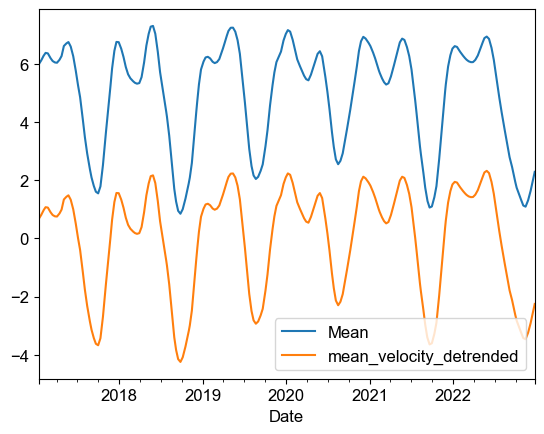

In [30]:
# load velocities from each section from csv 

# -----Velocity (all sections) 
vel_fn = os.path.join(data_path, 'data/compiled_timeseries_by_terminus_section', 'velocity_by_section.csv')
v_term = pd.read_csv(vel_fn)
v_term['Date'] = pd.to_datetime(v_term['Date'])
v_term.drop_duplicates(inplace=True)

# Resample to daily
v_term.set_index('Date', inplace=True)
v_term = v_term.resample('1D').interpolate('time')
v_term.reset_index(inplace=True)

v_term['Mean'] = v_term[[
    'section_A median |v| [m/yr]', 
    'section_B median |v| [m/yr]', #    'section_A median |v| [m/yr]', 
    'section_C median |v| [m/yr]',
    'section_D median |v| [m/yr]', 
    'section_E median |v| [m/yr]']].mean(axis=1)

v_term['Mean'] = v_term['Mean'] / 365 # Convert from m/y to m/d

v_term['mean_velocity_detrended'] = detrend(v_term['Mean'])

v_term.set_index('Date')[['Mean','mean_velocity_detrended']].plot()
print('Velocity loaded')

In [31]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month <= 0:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0

# Define year and biweek for grouping
air['Biweek'] = ((air['Date'].dt.isocalendar().week - 1) // 2) + 1  # Grouping into biweekly intervals
air['Year'] = air['Date'].dt.year

# Add a column for fake year and calculate PDD
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# Calculate biweekly average PDD and the first date of each biweek
air['biweekly_PDD'] = air.groupby(['Year', 'Biweek'])['PDD'].transform('mean')
air['day_of_year_PDD'] = air.groupby(['Year', 'Biweek'])['Date'].transform('first')

# Convert 'day_of_year_PDD' to the day of the year
air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# Optional: drop intermediate columns
air = air.drop(columns=['Biweek', 'Year'])

# Create a mask to filter for biweeks meeting the threshold within the first six months
mask = (air['biweekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# Find the first occurrence in each fake_year where the threshold is met
pdd_peaks = (
    air[mask]
    .groupby('fake_year')
    .apply(lambda x: x.loc[x['Date'].idxmin()])
    .reset_index(drop=True)
)

# Add color with the subset_fake_years_add_color function
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
 
# Max terminus advance
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_advance_detrended_m'].idxmax()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_advance_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)

# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)

# Add day of the year for each peak based on the 'Date' column
v_mins['day_of_year_vmin'] = term_peaks['Date'].dt.dayofyear
v_mins = subset_fake_years_add_color(v_mins)

### Summer speed peaks


# min between winter and summer
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 2) & ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values

# Extract the day of the year instead of the actual date for each minimum velocity
v_summer_peaks = v_term_summer.loc[ipeaks].reset_index(drop=True)
v_summer_peaks['day_of_year_vsum'] = v_summer_peaks['Date'].dt.dayofyear

# Drop the original 'Date' column if you only need the day of the year
v_summer_peaks = v_summer_peaks[['day_of_year_vsum', 'Date', 'Mean', 'fake_year']]

# Optionally, add color or additional processing with the subset_fake_years_add_color function
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed min
v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
v_term_winter['Year'] = v_term_winter['Date'].dt.year
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values

v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)


# Merge into one dataframe for regression plotting
peaks_merged = (v_mins[['fake_year', 'color', 'Mean', 'day_of_year_vmin']].merge(
    pdd_peaks[['fake_year', 'color', 'day_of_year_PDD', 'biweekly_PDD']].merge(
    term_peaks[['fake_year', 'Mean_advance_detrended_m']].merge(
        v_summer_peaks[['fake_year', 'Mean', 'day_of_year_vsum']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer')))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_13747/689796382.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Date'].idxmin()])
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_13747/689796382.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_13747/689796382.py:93: SettingWithCopyWarning

,fake_year,color,Mean,day_of_year_vmin,day_of_year_PDD,biweekly_PDD,Mean_advance_detrended_m,Mean_summer_peak,day_of_year_vsum,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",1.549577,113,100,5.951919,78.334174,6.044233,93,5.910703
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",0.848334,138,99,4.944168,125.377963,5.323242,78,4.141975
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",2.044272,153,70,5.757740,99.425992,6.031805,53,6.016363
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",2.552221,148,111,5.833389,66.016637,5.438686,98,5.438686
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",1.061368,172,102,5.145728,111.581786,5.293185,72,5.293185
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",1.091779,157,115,5.319648,95.492342,6.063414,77,NaN


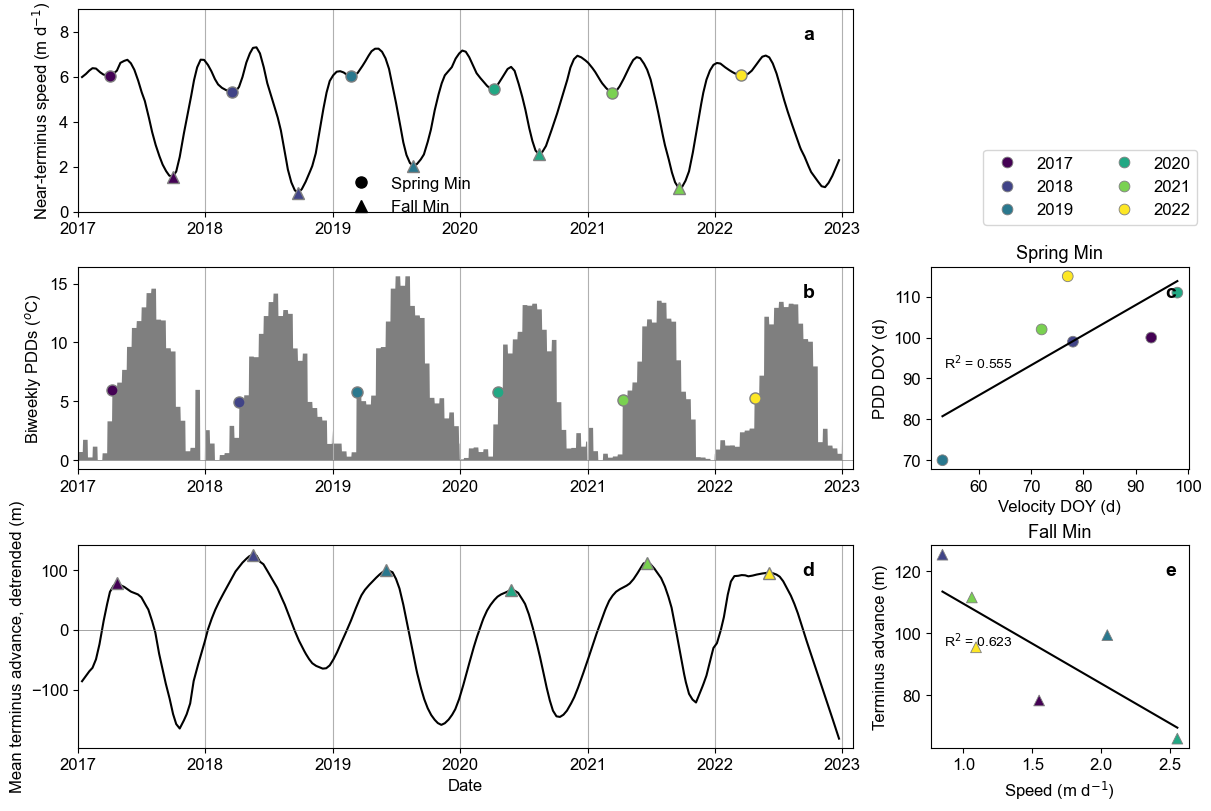

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus_mean.png


In [34]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 2, figsize=(12,8), gridspec_kw={'width_ratios': [3,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, min, color in v_mins[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, min, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Spring Min')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Fall Min')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.605, 0.2, 0.2])
ax[0,0].set_ylim(0,9)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')


#PDD
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['biweekly_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'biweekly_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Biweekly PDDs ($^o$C)')


ax[2,0].plot(term['Date'], term['Mean_advance_detrended_m'], '-k')
for date, advance, color in term_peaks[['Date', 'Mean_advance_detrended_m', 'color']].values:
    ax[2,0].plot(date, advance, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
     
ax[2,0].set_ylabel('Mean terminus advance, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2017-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
    
# PDD-Spring
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
# ax[1,1].set_xlabel('Day of year (d)')
# ax[1,1].set_ylabel('Day of year (d)')
ax[1,1].set_xlabel('Velocity DOY (d)')
ax[1,1].set_ylabel('PDD DOY (d)')

ax[1,1].set_title('Spring Min', fontsize=fontsize+1)

# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017', '2018', '2019', '2020', '2021', '2022']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.7, 0.63, 0.3, 0.2], ncols=2)

# Terminus - Fall
sns.scatterplot(data=peaks_merged, x='Mean', y='Mean_advance_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), marker = '^', s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean', 'Mean_advance_detrended_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('Terminus advance (m)')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
ax[2,1].set_title('Fall Min', fontsize=fontsize+1)

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1],
                             ax[2,0], ax[2,1]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus_mean.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)